# Trading Agent Development
Inspiration:
- https://www.backtrader.com/blog/posts/2015-08-16-backtesting-with-almost-no-programming/backtesting-with-almost-no-programming/ (Backtrader Platform würde einige Funktionen bereitstellen)
- https://github.com/tmorgan4/btgym_Kismuz?tab=readme-ov-file
- 

In [16]:
import src.utils.file_management as filemgmt
import src.pipeline.preprocessing as preprocessing
import src.pipeline.predictors as predictors
from src.pipeline.predictors import LSTMPredictor
from src.pipeline.rl_environments import RLTradingEnv
from src.pipeline.rl_agents import MultiProductAgent 
from src.pipeline.financial_products import KOCertificate, KOCertificateSet

from itertools import product
import gym
from gym import spaces
from typing import Union, Literal
import numpy as np
import pandas as pd
import random
import enum

from pathlib import Path

from tqdm import tqdm
from alpha_vantage.timeseries import TimeSeries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from matplotlib.lines import Line2D

import matplotlib.pyplot as plt

## Initialisation

In [2]:
#matplotlib backend:
try:
    %matplotlib macosx
except BaseException:
    %matplotlib macosx
    # sometimes takes two tries...
    
# opens in separate window

#%matplotlib notebook
# opens in notebook

In [3]:
ROOT = Path().resolve().parent

DATA = ROOT / "data"
INTERPOLATED_PRICES = DATA / "interpolated_prices"
#INTERPOLATED_SMOOTHED_PRICES = DATA / "interpolated_smoothed_prices"

SAVED_MODELS = DATA / "saved_models"

In [4]:
#SAVED_MA_A2_PREDICTOR = SAVED_MODELS / "smoothed_data" / "predictor_a2" / "2025-06-24 08_15_45 LSTM Model RW32 FH16 Layers3 Size128 TrainL0.0391070676560048 ValL4.186663746833801 TrainHR0.5056179761886597 ValHR0.5342960357666016.pt"
SAVED_B1_PREDICTOR = SAVED_MODELS / "predictor_b1" / "2025-05-22 10_03_41 LSTM Model RW68 FH14 Layers3 Size256 TrainL0.10641186928842217 ValL1.9110333621501923 TrainHR0.4860040545463562 ValHR0.5328466892242432.pt"
#SAVED_MA_B1_PREDICTOR = SAVED_MODELS / "smoothed_data" / "predictor_b1" / "2025-06-24 01_24_08 LSTM Model RW64 FH14 Layers3 Size256 TrainL0.08817749086301774 ValL4.741025149822235 TrainHR0.494169682264328 ValHR0.505415141582489.pt"
SAVED_B3_PREDICTOR = SAVED_MODELS / "predictor_b3" / "2025-05-22 11_47_10 LSTM Model RW40 FH5 Layers3 Size128 TrainL0.36055382899940014 ValL1.9578219056129456 TrainHR0.547325074672699 ValHR0.529629647731781.pt"
#SAVED_MA_B3_PREDICTOR = SAVED_MODELS / "smoothed_data" / "predictor_b3" / "2025-06-24 00_51_15 LSTM Model RW40 FH5 Layers4 Size256 TrainL0.19968504621647298 ValL2.088192492723465 TrainHR0.6400325894355774 ValHR0.5714285969734192.pt"
SAVED_C1_PREDICTOR = SAVED_MODELS / "predictor_c1" / "2025-05-22 11_27_18 LSTM Model RW24 FH3 Layers4 Size128 TrainL0.29682125337421894 ValL0.4320639967918396 TrainHR0.5574468374252319 ValHR0.5660377144813538.pt"
#SAVED_MA_C1_PREDICTOR = SAVED_MODELS / "smoothed_data" / "predictor_c1" / "2025-06-23 23_27_16 LSTM Model RW24 FH3 Layers4 Size128 TrainL0.15201090183109045 ValL0.37886202335357666 TrainHR0.6189473867416382 ValHR0.49056604504585266.pt"

In [5]:
ENV_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '15min')  #filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '15min')
B1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '60min')
B3_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '1d')
C1_PRICE_FILE = filemgmt.most_recent_file(INTERPOLATED_PRICES, '.csv', '7d')
MEAN_ETF_INDEX_RATIO = 543.3079783216567  # because files are etf prices

## Products

In [ ]:
dax_long1 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000TT2CH77',
                         date_base_price_tuple2=("2022-09-26 12:00:00", 10300)
                         # historic_date_future_price_tuple=("2022-09-26", 6.49),
                        )
dax_long1.plot()
dax_long1

In [ ]:
dax_long1 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000TT2CH77',
                         date_base_price_tuple2=("2022-09-26 12:00:00", 10300)
                         # historic_date_future_price_tuple=("2022-09-26", 6.49),
                        )
dax_long1.plot()
dax_long1

In [ ]:
dax_long2 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000HS3U0K3',
                          direction='long',
                        )
dax_long2

In [ ]:
dax_short1 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000HT2PK31',
                         #historic_date_future_price_tuple=("2024-01-08", 1.31),
                        )
dax_short1.plot()
dax_short1

In [ ]:
dax_short2 = KOCertificate(preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
                         isin='DE000HT2LDF5',
                        )
dax_short2

### Portfolio

In [6]:
portfolio = KOCertificateSet(
    underlying_price_series=preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
    base_price_inference_timestamps=["2020-07-06 10:00:00", "2022-07-05 10:00:00", "2024-01-05 10:00:00"], # "2023-07-05 10:00:00", "2024-07-05 10:00:00", "2025-03-05 10:00:00"],
    n_products_per_direction=15,
    lowest_leverage=1.0, highest_leverage=10.0)


30it [00:00, 62.49it/s]
30it [00:00, 64.72it/s]
30it [00:00, 53.41it/s]


In [103]:
portfolio.future_product_instances += portfolio.initialise_products_from_leverage(underlying_price_series=preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
    base_price_inference_timestamps=["2017-12-08 10:00:00", "2018-07-05 10:00:00"],
    n_products_per_direction=15, issue_date="2017-01-01 10:00:00",
    lowest_leverage=1.0, highest_leverage=10.0)

30it [00:00, 32.88it/s]
30it [00:00, 35.12it/s]


In [104]:
portfolio.future_product_instances += portfolio.initialise_products_from_leverage(underlying_price_series=preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
    base_price_inference_timestamps=["2021-07-06 10:00:00", "2023-07-05 10:00:00", "2024-07-05 10:00:00", "2025-03-05 10:00:00"],
    n_products_per_direction=15, issue_date="2020-06-01 10:00:00",
    lowest_leverage=1.0, highest_leverage=10.0)

30it [00:00, 49.30it/s]
30it [00:00, 51.77it/s]
30it [00:00, 43.75it/s]
30it [00:00, 40.92it/s]


In [105]:
portfolio.future_product_instances += portfolio.initialise_products_from_leverage(underlying_price_series=preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
    base_price_inference_timestamps=["2023-05-05 10:00:00", "2024-07-05 10:00:00", "2025-03-05 10:00:00"],
    n_products_per_direction=15, issue_date="2022-12-01 10:00:00",
    lowest_leverage=1.0, highest_leverage=10.0)

30it [00:00, 85.13it/s]
30it [00:00, 73.84it/s]
30it [00:00, 60.89it/s]


In [106]:
portfolio.future_product_instances += portfolio.initialise_products_from_leverage(underlying_price_series=preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
    base_price_inference_timestamps=["2025-03-05 10:00:00"],
    n_products_per_direction=15, issue_date="2024-03-03 10:00:00",
    lowest_leverage=1.0, highest_leverage=10.0)

30it [00:00, 83.29it/s]


In [107]:
portfolio.future_product_instances += portfolio.initialise_products_from_leverage(underlying_price_series=preprocessing.read_price_csv(ENV_PRICE_FILE) * MEAN_ETF_INDEX_RATIO,
    base_price_inference_timestamps=["2025-03-07 12:00:00"],
    n_products_per_direction=15, issue_date="2024-03-03 10:00:00",
    lowest_leverage=1.0, highest_leverage=10.0)

30it [00:00, 87.57it/s]


In [48]:
portfolio.plot_leverages()

In [7]:
{product.isin: product.base_price_change_per_annum for product in portfolio.future_product_instances}

{'ARTIFLO0000': 0.02,
 'ARTIFLO0001': 0.02,
 'ARTIFLO0002': 0.02,
 'ARTIFLO0003': 0.02,
 'ARTIFLO0004': 0.02,
 'ARTIFLO0005': 0.02,
 'ARTIFLO0006': 0.02,
 'ARTIFLO0007': 0.02,
 'ARTIFLO0008': 0.02,
 'ARTIFLO0009': 0.02,
 'ARTIFLO0010': 0.02,
 'ARTIFLO0011': 0.02,
 'ARTIFLO0012': 0.02,
 'ARTIFLO0013': 0.02,
 'ARTIFLO0014': 0.02,
 'ARTIFSH0015': -0.02,
 'ARTIFSH0016': -0.02,
 'ARTIFSH0017': -0.02,
 'ARTIFSH0018': -0.02,
 'ARTIFSH0019': -0.02,
 'ARTIFSH0020': -0.02,
 'ARTIFSH0021': -0.02,
 'ARTIFSH0022': -0.02,
 'ARTIFSH0023': -0.02,
 'ARTIFSH0024': -0.02,
 'ARTIFSH0025': -0.02,
 'ARTIFSH0026': -0.02,
 'ARTIFSH0027': -0.02,
 'ARTIFSH0028': -0.02,
 'ARTIFSH0029': -0.02,
 'ARTIFLO0030': 0.02,
 'ARTIFLO0031': 0.02,
 'ARTIFLO0032': 0.02,
 'ARTIFLO0033': 0.02,
 'ARTIFLO0034': 0.02,
 'ARTIFLO0035': 0.02,
 'ARTIFLO0036': 0.02,
 'ARTIFLO0037': 0.02,
 'ARTIFLO0038': 0.02,
 'ARTIFLO0039': 0.02,
 'ARTIFLO0040': 0.02,
 'ARTIFLO0041': 0.02,
 'ARTIFLO0042': 0.02,
 'ARTIFLO0043': 0.02,
 'ARTIFLO0044': 0

In [102]:
avail_frame = portfolio.get_leverage_availability("long", hour_minute_to_check=(20, 0))

Availability of leverage >1.0: 99.85559566787003 %
Availability of leverage >2.0: 91.6606498194946 %
Availability of leverage >3.0: 49.96389891696751 %
Availability of leverage >4.0: 32.34657039711191 %


In [108]:
avail_frame = portfolio.get_leverage_availability("short", hour_minute_to_check=(20, 0))

Availability of leverage >1.0: 100.0 %
Availability of leverage >2.0: 97.14801444043322 %
Availability of leverage >3.0: 81.44404332129965 %
Availability of leverage >4.0: 67.25631768953069 %


## Predictors

In [109]:
'''a2_predictor = LSTMPredictor(model_load_file_path=SAVED_A2_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=B1_PRICE_FILE,
                             daily_prediction_hour=16,  # these are necessary data properties which still need to be set
                             predict_before_daily_prediction_hour=False,
                             rolling_window_size=32,  # 8 hours behind
                             forecast_horizon=16,  # 4 hours ahead
                             sampling_rate_minutes=15)  # quarter
a2_predictor'''

NameError: name 'SAVED_A2_PREDICTOR' is not defined

In [10]:
b1_predictor = LSTMPredictor(model_load_file_path=SAVED_B1_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=B1_PRICE_FILE,
                             daily_prediction_hour=16,  # these are necessary data properties which still need to be set
                             predict_before_daily_prediction_hour=True,
                             rolling_window_size=14*4+8,  # 1 week hindsight (4 days a 14 hours and 1 a 8 hours until 16.00)
                             forecast_horizon=14,  # 1 day a 14 hours ahead
                             sampling_rate_minutes=60)  # hourly
b1_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.
Created rolling window view based on rolling_window_size of 64 and forecast_horizon of 14 with a time unit of 60 minutes.
Target values start at only observation between 16:00 and 17:00 daily.
Resulting dataset consists of 2764 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 2211 training and 553 validation observations.


------------------- LSTMPredictor Instance -------------------

Data Attributes:
- sampling rate: 60 min (= 1.0 h = 0.07142857142857142 d)
- rolling window size: 64
- forecast horizon: 14
- daily prediction hour: 16:00
- predicting at last observation before prediction hour: True
- validation split: 0.2
- amount of training observations: 2211
- amount of validation observations: 553

Model Attributes:
- hidden LSTM layers: 256
- number of LSTM layers: 3
- pre LSTM fully connected layer: False

Model wasn't trained yet (or was imported).

In [11]:
b3_predictor = LSTMPredictor(model_load_file_path=SAVED_B3_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=B3_PRICE_FILE,
                             daily_prediction_hour=16,  # these are necessary data properties which still need to be set
                             rolling_window_size=2*4*5,  # 2 months a 4 weeks a 5 days hindsight
                             forecast_horizon=5,  # 1 week a 5 days ahead
                             sampling_rate_minutes=60*14,  # one day from 8 to 22
                             )
b3_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.
Created rolling window view based on rolling_window_size of 40 and forecast_horizon of 5 with a time unit of 840 minutes.
Target values start at only observation between 16:00 and 17:00 daily.
Resulting dataset consists of 2726 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 2180 training and 546 validation observations.


------------------- LSTMPredictor Instance -------------------

Data Attributes:
- sampling rate: 840 min (= 14.0 h = 1.0 d)
- rolling window size: 40
- forecast horizon: 5
- daily prediction hour: 16:00
- predicting at last observation before prediction hour: False
- validation split: 0.2
- amount of training observations: 2180
- amount of validation observations: 546

Model Attributes:
- hidden LSTM layers: 128
- number of LSTM layers: 3
- pre LSTM fully connected layer: False

Model wasn't trained yet (or was imported).

In [12]:
b1_predictor.plot_prediction_overview()

Using CPU


 40%|████      | 222/553 [00:03<00:05, 62.07it/s]


KeyboardInterrupt: 

In [13]:
c1_predictor = LSTMPredictor(model_load_file_path=SAVED_C1_PREDICTOR,  # based on this, the predictor infers the model's properties
                             price_csv_path=C1_PRICE_FILE,
                             daily_prediction_hour=16,  # these are necessary data properties which still need to be set
                             rolling_window_size=6*4,  # 6 months a 4 weeks hindsight
                             forecast_horizon=3,  # 3 weeks ahead
                             sampling_rate_minutes=5*14*60,  # 1 week a 5 days from 8 to 22
                             )
c1_predictor

No training epochs defined upon initialisation. Define LSTMPredictor.n_train_epochs to start training procedure.
Created rolling window view based on rolling_window_size of 24 and forecast_horizon of 3 with a time unit of 4200 minutes.
Target values start at only observation between 16:00 and 17:00 daily.
Resulting dataset consists of 528 observations.
Using last 20.0% of data for validation. Other data for training.
This yields 422 training and 106 validation observations.


------------------- LSTMPredictor Instance -------------------

Data Attributes:
- sampling rate: 4200 min (= 70.0 h = 5.0 d)
- rolling window size: 24
- forecast horizon: 3
- daily prediction hour: 16:00
- predicting at last observation before prediction hour: False
- validation split: 0.2
- amount of training observations: 422
- amount of validation observations: 106

Model Attributes:
- hidden LSTM layers: 128
- number of LSTM layers: 4
- pre LSTM fully connected layer: False

Model wasn't trained yet (or was imported).

### Example Prediction

## Environment
https://github.com/tmorgan4/btgym_Kismuz/blob/master/btgym/strategy/base.py

### V2 (Future Products
- fixed ratio of portfolio can be invested in each category (leverage and direction)

In [14]:
self = RLTradingEnv(ENV_PRICE_FILE,
                    price_sampling_rate_minutes=15,
                    predictor_instances=(b3_predictor, c1_predictor),
                    product_set=portfolio, trading_quantity_per_leverage_factor=.5,
                    include_open_leverage_category=False,
                    leverage_categories=(1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0))#, 5.5, 6.0, 6.5, 7.0))

Starting at 2015-4-9 although data is provided since 2014-10-23 to have sufficient information for all predictors.


In [15]:
self.action_enum_dict

{0: 'Hold',
 1: 'Buy long 1.0x - 1.5x',
 2: 'Sell long 1.0x - 1.5x',
 3: 'Buy short 1.0x - 1.5x',
 4: 'Sell short 1.0x - 1.5x',
 5: 'Buy long 1.5x - 2.0x',
 6: 'Sell long 1.5x - 2.0x',
 7: 'Buy short 1.5x - 2.0x',
 8: 'Sell short 1.5x - 2.0x',
 9: 'Buy long 2.0x - 2.5x',
 10: 'Sell long 2.0x - 2.5x',
 11: 'Buy short 2.0x - 2.5x',
 12: 'Sell short 2.0x - 2.5x',
 13: 'Buy long 2.5x - 3.0x',
 14: 'Sell long 2.5x - 3.0x',
 15: 'Buy short 2.5x - 3.0x',
 16: 'Sell short 2.5x - 3.0x',
 17: 'Buy long 3.0x - 3.5x',
 18: 'Sell long 3.0x - 3.5x',
 19: 'Buy short 3.0x - 3.5x',
 20: 'Sell short 3.0x - 3.5x',
 21: 'Buy long 3.5x - 4.0x',
 22: 'Sell long 3.5x - 4.0x',
 23: 'Buy short 3.5x - 4.0x',
 24: 'Sell short 3.5x - 4.0x',
 25: 'Buy long 4.0x - 4.5x',
 26: 'Sell long 4.0x - 4.5x',
 27: 'Buy short 4.0x - 4.5x',
 28: 'Sell short 4.0x - 4.5x',
 29: 'Buy long 4.5x - 5.0x',
 30: 'Sell long 4.5x - 5.0x',
 31: 'Buy short 4.5x - 5.0x',
 32: 'Sell short 4.5x - 5.0x'}

In [122]:
obs, _, _, info = self.step(1)
print(obs)
print(info)
self.open_positions

[STEP 127] Bought 8.0 shares of ARTIFLO0000 (long with leverage in (1.0, 2.0)) at 12012.817716844156.
    Cash: 611624.2178693948, Holding: 363201.5439305113
[-9.12100080e-03  7.73821181e-03  6.11624218e+05  3.63201544e+05]
{'Step': 127, 'Time': '2015-04-20 16:00:00', 'Reward': -69.97, 'Action': 'Buy long 1.0x - 2.0x', 'Avg. Expected Potential': -0.0006913944940260541, 'Total Exposure': 0.4924292061295572, 'Cash': 611624.22, 'Total': 974825.76}


,Shares,Leverage,Price,Direction,% Portfolio
ARTIFLO0000,8.0,1.000000,12000.816900,long,9.848584
ARTIFLO0006,64.0,4.452563,2695.260642,long,17.695130
ARTIFSH0058,32.0,4.055258,2959.322740,short,9.714385


## Agent

## Run

In [17]:
agent = MultiProductAgent(observation_types=['potential']*len(self.predictor_instances) + ['cash', 'holding'],
                          n_leverage_categories=len(self.leverage_categories),
                          abs_potential_treshold_steps=(.0025, .0075, .035),
                          include_open_leverage_category=self.include_open_leverage_category)

In [18]:
agent

------------------- KOCertificate Instance -------------------

Threshold-action mapping:
      -inf < potential < -0.03500  -->  action 3
  -0.03500 < potential < -0.03107  -->  action 7
  -0.03107 < potential < -0.02714  -->  action 11
  -0.02714 < potential < -0.02321  -->  action 15
  -0.02321 < potential < -0.01929  -->  action 19
  -0.01929 < potential < -0.01536  -->  action 23
  -0.01536 < potential < -0.01143  -->  action 27
  -0.01143 < potential < -0.00750  -->  action 31
  -0.00750 < potential < -0.00687  -->  action 2
  -0.00687 < potential < -0.00625  -->  action 6
  -0.00625 < potential < -0.00562  -->  action 10
  -0.00562 < potential < -0.00500  -->  action 14
  -0.00500 < potential < -0.00437  -->  action 18
  -0.00437 < potential < -0.00375  -->  action 22
  -0.00375 < potential < -0.00313  -->  action 26
  -0.00313 < potential < -0.00250  -->  action 30
  -0.00250 < potential <  0.00250  -->  action 0
   0.00250 < potential <  0.00313  -->  action 4
   0.00313 < pot

In [137]:
obs = self.reset()  # reset episode and fetch first observation
self.verbose = False
done = False  # episode termination criterion

# initialise log frame
log = pd.DataFrame()
for ind in tqdm(range(self.current_step, self.total_steps)):
    action, _ = agent.predict(obs)  # infer action
    obs, _, done, info = self.step(action)  # retrieve new observation and info
    
    if done: break  # check whether episode is finished
    log = pd.concat([log, pd.DataFrame(info, index=[info['Step']])])  # log info

  0%|          | 0/2650 [00:00<?, ?it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|          | 16/2650 [00:00<00:57, 45.78it/s]

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  1%|          | 21/2650 [00:01<05:52,  7.46it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: Runtim

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  1%|▏         | 34/2650 [00:20<45:46,  1.05s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|▏         | 35/2650 [00:21<49:17,  1.13s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  1%|▏         | 36/2650 [00:23<52:04,  1.20s/it]/Users/paulrusing/minicon

No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  2%|▏         | 44/2650 [00:28<25:45,  1.69it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 45/2650 [00:29<27:53,  1.56it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 46/2650 [00:30<29:49,  1.45it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 47/2650 [00:31<31:21,  1.38it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 48/2650 [00:32<38:32,  1.12it/s]/Users/paulrusing/minicon

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 49/2650 [00:33<37:59,  1.14it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 50/2650 [00:34<37:27,  1.16it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 51/2650 [00:35<37:07,  1.17it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 52/2650 [00:36<36:51,  1.17it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 53/2650 [00:37<43:14,  1.00it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 54/2650 [00:38<41:09,  1.05it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 55/2650 [00:39<39:37,  1.09it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 56/2650 [00:39<38:28,  1.12it/s]/Users/paulrusing/minicon

No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  2%|▏         | 58/2650 [00:42<41:50,  1.03it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  2%|▏         | 59/2650 [00:42<40:10,  1.08it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (5.0, 5.5) found. Using next smaller leverage.


  2%|▏         | 60/2650 [00:43<38:53,  1.11it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  2%|▏         | 61/2650 [00:44<38:03,  1.13it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 62/2650 [00:45<37:28,  1.15it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 63/2650 [00:46<36:55,  1.17it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  2%|▏         | 64/2650 [00:47<36:31,  1.18it/s]/Users/paulrusing/minicon

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 65/2650 [00:47<36:25,  1.18it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  2%|▏         | 66/2650 [00:48<36:16,  1.19it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  3%|▎         | 67/2650 [00:49<36:10,  1.19it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  3%|▎         | 68/2650 [00:50<32:39,  1.32it/s]/Users/paulrusing/minicon

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  3%|▎         | 73/2650 [00:55<45:30,  1.06s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (5.5, 6.0) found. Using next smaller leverage.


  3%|▎         | 74/2650 [00:56<42:32,  1.01it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (5.5, 6.0) found. Using next smaller leverage.


  3%|▎         | 75/2650 [00:57<40:26,  1.06it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  3%|▎         | 76/2650 [00:58<39:05,  1.10it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  3%|▎         | 77/2650 [00:59<44:44,  1.04s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  3%|▎         | 78/2650 [01:01<48:39,  1.13s/it]/Users/paulrusing/minicon

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  3%|▎         | 91/2650 [01:16<49:37,  1.16s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  3%|▎         | 92/2650 [01:17<46:25,  1.09s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▎         | 93/2650 [01:18<50:07,  1.18s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▎         | 94/2650 [01:19<52:24,  1.23s/it]/Users/paulrusing/minicon

No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  4%|▍         | 100/2650 [01:25<41:03,  1.04it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 101/2650 [01:26<39:18,  1.08it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 102/2650 [01:27<37:57,  1.12it/s]/Users/paulrusing/mini

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  4%|▍         | 106/2650 [01:31<40:24,  1.05it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  4%|▍         | 107/2650 [01:32<38:51,  1.09it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  4%|▍         | 108/2650 [01:32<37:44,  1.12it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 109/2650 [01:34<43:38,  1.03s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 110/2650 [01:35<47:39,  1.13s/it]/Users/paulrusing/mini

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  4%|▍         | 111/2650 [01:36<43:58,  1.04s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  4%|▍         | 112/2650 [01:37<41:19,  1.02it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  4%|▍         | 113/2650 [01:38<39:21,  1.07it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (5.5, 6.0) found. Using next smaller leverage.


  4%|▍         | 114/2650 [01:38<38:04,  1.11it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (5.5, 6.0) found. Using next smaller leverage.


  4%|▍         | 115/2650 [01:39<37:18,  1.13it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  4%|▍         | 116/2650 [01:40<36:41,  1.15it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  4%|▍         | 117/2650 [01:41<36:14,  1.16it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  4%|▍         | 118/2650 [01:42<35:52,  1.18it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  4%|▍         | 119/2650 [01:43<35:42,  1.18it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|▍         | 120/2650 [01:44<42:06,  1.00it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  5%|▍         | 121/2650 [01:45<39:55,  1.06it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|▍         | 122/2650 [01:46<38:25,  1.10it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|▍         | 123/2650 [01:46<37:18,  1.13it/s]/Users/paulrusing/mini

No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  5%|▌         | 133/2650 [01:56<41:04,  1.02it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  5%|▌         | 134/2650 [01:57<39:16,  1.07it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  5%|▌         | 135/2650 [01:58<37:54,  1.11it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (5.5, 6.0) found. Using next smaller leverage.


  5%|▌         | 136/2650 [01:58<37:03,  1.13it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (5.0, 5.5) found. Using next smaller leverage.


  5%|▌         | 137/2650 [01:59<36:21,  1.15it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (5.5, 6.0) found. Using next smaller leverage.


  5%|▌         | 138/2650 [02:00<35:59,  1.16it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  5%|▌         | 139/2650 [02:01<35:41,  1.17it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  5%|▌         | 140/2650 [02:02<35:24,  1.18it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  5%|▌         | 141/2650 [02:03<35:15,  1.19it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  5%|▌         | 142/2650 [02:03<35:01,  1.19it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|▌         | 143/2650 [02:05<41:26,  1.01it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  5%|▌         | 144/2650 [02:06<45:51,  1.10s/it]/Users/paulrusing/mini

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  6%|▌         | 146/2650 [02:08<44:39,  1.07s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  6%|▌         | 147/2650 [02:09<41:35,  1.00it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  6%|▌         | 148/2650 [02:10<39:37,  1.05it/s]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|▌         | 149/2650 [02:11<44:38,  1.07s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|▌         | 150/2650 [02:13<48:05,  1.15s/it]/Users/paulrusing/mini

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  6%|▋         | 167/2650 [02:42<59:18,  1.43s/it]  /Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|▋         | 168/2650 [02:44<1:03:55,  1.55s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  6%|▋         | 169/2650 [02:45<1:07:13,  1.63s/it]/Users/paulrusin

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  7%|▋         | 173/2650 [02:52<1:03:51,  1.55s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  7%|▋         | 174/2650 [02:53<58:20,  1.41s/it]  /Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 175/2650 [02:55<1:03:07,  1.53s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 176/2650 [02:57<1:06:38,  1.62s/it]/Users/paulrusin

No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  7%|▋         | 186/2650 [03:08<47:00,  1.14s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 187/2650 [03:10<54:22,  1.32s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  7%|▋         | 188/2650 [03:11<51:52,  1.26s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 189/2650 [03:13<58:29,  1.43s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  7%|▋         | 190/2650 [03:14<54:21,  1.33s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 191/2650 [03:16<59:30,  1.45s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  7%|▋         | 192/2650 [03:17<54:55,  1.34s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  7%|▋         | 193/2650 [03:18<51:53,  1.27s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.0, 6.5) found. Using next smaller leverage.


  7%|▋         | 194/2650 [03:19<49:25,  1.21s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No product with leverage inside (6.5, 7.0) found. Using next smaller leverage.


  7%|▋         | 195/2650 [03:20<52:53,  1.29s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 196/2650 [03:23<1:09:51,  1.71s/it]/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/paulrusing/miniconda3/envs/pru_dev2/envs/rl_env/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
  7%|▋         | 197/2650 [03:24<1:00:25,  1.48s/it]/Users/paulrusing/

KeyboardInterrupt: 

In [138]:
benchmark = self.starting_cash / self.price_series.loc[log['Time'].iloc[0]] * self.price_series.loc[log['Time']]  # construct benchmark return if HODL
log.set_index('Time', inplace=True)
log['Benchmark'] = benchmark
log


,Step,Reward,Action,Avg. Expected Potential,Total Exposure,Cash,Total,Benchmark
Time,,,,,,,,
2015-04-10 16:00:00,121,0.00,Hold,0.002012,0.000000,1000000.00,1000000.00,1.000000e+06
2015-04-13 16:00:00,122,0.00,Hold,0.002648,0.000000,1000000.00,1000000.00,1.004351e+06
2015-04-14 16:00:00,123,0.00,Sell short 1.0x - 1.5x,0.001843,0.000000,1000000.00,1000000.00,1.001501e+06
2015-04-15 16:00:00,124,0.00,Hold,0.002587,0.000000,1000000.00,1000000.00,1.002326e+06
2015-04-16 16:00:00,125,0.00,Sell short 1.0x - 1.5x,0.003370,0.000000,1000000.00,1000000.00,9.939957e+05
...,...,...,...,...,...,...,...,...
2016-01-06 16:00:00,314,10789.42,Buy short 6.0x - 6.5x,-0.009159,-0.720662,579605.78,1049074.12,8.285194e+05
2016-01-07 16:00:00,315,5844.63,Buy short 6.5x - 7.0x,-0.003734,-0.787871,543220.62,1054918.74,8.219716e+05
2016-01-08 16:00:00,316,932.10,Sell long 5.5x - 6.0x,-0.002317,-0.786196,543220.62,1055850.84,8.209490e+05


In [139]:
val_df = log.loc[:, ['Avg. Expected Potential', 'Total Exposure']]
val_df['Policy'] = log['Total'] / log['Benchmark'].iloc[0]
val_df['Benchmark'] = log['Benchmark'] / log['Benchmark'].iloc[0]

fig, (return_ax, exposure_ax) = plt.subplots(2, 1, figsize=(14, 14))
potential_ax = exposure_ax.twinx()
dates = pd.to_datetime(log.index)

# portfolio performance:
return_ax.plot(dates, val_df['Policy'], color='orange', label='Policy')
return_ax.plot(dates, val_df['Benchmark'], color='blue', label='Benchmark')
return_ax.set_title('Normalized Policy vs. Benchmark')
return_ax.set_xlabel('Date')
return_ax.set_ylabel('Normalized Balance')
return_ax.legend()
return_ax.grid(True)

# include potential thresholds:
if isinstance(agent, MultiProductAgent):
    for ind, (threshold, sign) in enumerate(product(agent.abs_potential_treshold_steps, [-1, 1])):
        potential_ax.axhline(y=threshold*sign*100, color='purple',
                    linestyle=':', alpha=.3,
                    label='Action Thresholds' if ind == 0 else '_',  # create legend entry only for first line
                    )
    
# avg potential:
potential_ax.plot(dates, val_df['Avg. Expected Potential']*100, color='black', linestyle='dashed', label='Avg. Expected Potential', alpha=.5)

# portfolio exposure:
pos_leverage = np.where(val_df['Total Exposure'] >= 0, val_df['Total Exposure'], np.nan)
neg_leverage = np.where(val_df['Total Exposure'] < 0, val_df['Total Exposure'], np.nan)
exposure_ax.plot(dates, pos_leverage, color='green', label='Positive Exposure')
exposure_ax.plot(dates, neg_leverage, color='red', label='Negative Exposure')

# formatting:
exposure_ax.set_xlabel('Date')
exposure_ax.legend(loc='upper left'); potential_ax.legend(loc='lower right')
exposure_ax.set_ylabel('Total Exposure'); potential_ax.set_ylabel('Expected Forward Potential [%]')
exposure_ax.set_ylim([-5, 5]); potential_ax.set_ylim([-5, 5])
exposure_ax.set_title('Portfolio Exposure and Predicted Potential')
exposure_ax.grid(True)

plt.show()

In [46]:
val_df['Total Exposure'] = log['Total Exposure']
val_df

,Policy,Benchmark,Avg. Exposure
Time,,,
2015-04-10 16:00:00,1.000000,1.000000,0.000000
2015-04-13 16:00:00,1.000000,1.004351,0.000000
2015-04-14 16:00:00,1.000000,1.001501,0.000000
2015-04-15 16:00:00,1.000000,1.002326,0.000000
2015-04-16 16:00:00,1.000000,0.993996,0.000000
...,...,...,...
2025-05-28 16:00:00,5.137522,1.944323,-3.220084
2025-05-29 16:00:00,5.183855,1.939073,-3.182685
2025-05-30 16:00:00,5.153650,1.942818,-3.207522


In [85]:
agent.abs_potential_treshold_steps

(0.0025, 0.0075, 0.03)

Prices are expected to go UP!


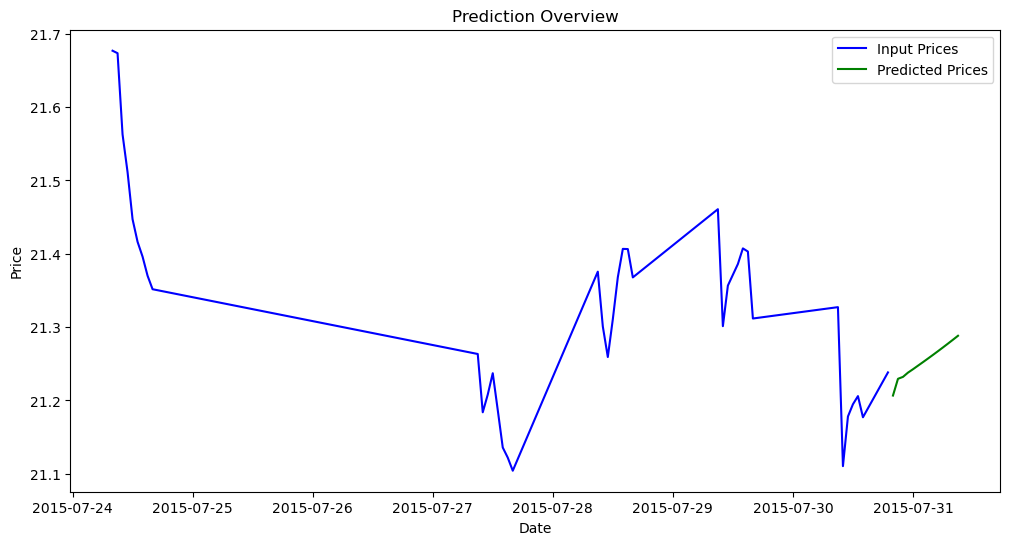

In [32]:
predictor = self.predictor_instances[0]
input = self.get_current_predictor_input(predictor)

prices, dates = predictor.predict(input)
potential = (prices[-1] / input.iloc[-1] - 1).item()

In [25]:
potential

0.0003994251627850165